In [1]:
import lightning as L
from torchvision.transforms import v2
import torchvision
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
from matplotlib import pyplot as plt
import torchmetrics
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import TQDMProgressBar, ModelCheckpoint
import numpy as np

from tqdm import tqdm
from pathlib import Path

In [3]:
config = {
    "batch_size": 32,
    "learning_rate": 0.001,
    "num_workers": 5,
    "epochs": 10,

    "checkpoint_dir": "~/ml/models/badapple_in_nn",
    "checkpoint_filename": "badapple_in_nn-{epoch:02d}-{val_acc:.2f}",
    "onnx_path": "~/ml/models/badapple_in_nn/badapple_in_nn.onnx",

    "logger": "~/ml/logs/badapple_in_nn",
    "log_name": "bad_apple_nn",

    "badapple_video": "./assets/Bad Apple.mp4",
    "badapple_frames": "./assets/frames"
}

def replace_home():
    global config
    home_dir = Path.home()

    for key, value in config.items():
        if isinstance(value, str):
            config[key] = value.replace("~", str(home_dir.absolute()))

replace_home()

images.dtype=torch.float32
labels.dtype=torch.int64
tensor([3, 8, 5, 6, 6, 9, 3, 4, 0])
torch.int64
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


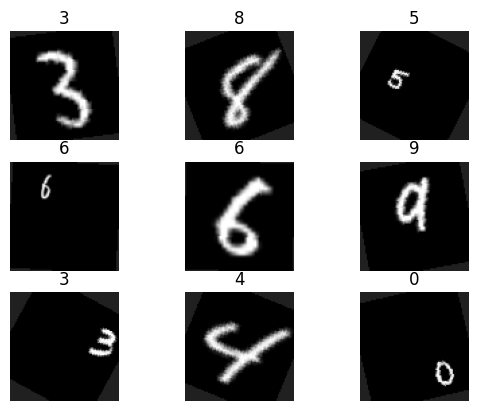

In [162]:
def get_loaders(batch_size=32):
    transforms = v2.Compose([
        v2.RandomZoomOut(),
        v2.Resize((81, 81)),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.1307,), (0.3081,)),
        v2.RandomRotation(30),
        # v2.Lambda(lambda x: torch.flatten(x)),
    ])
    dataset = torchvision.datasets.MNIST(
        "~/ml/datasets/MNIST",
        download=True,
        transform=transforms,
    )

    train, val = data.random_split(dataset, [55000, 5000])

    train_loader = data.DataLoader(
        train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=5,
        pin_memory=True
    )

    val_loader = data.DataLoader(
        val,
        batch_size=batch_size,
        num_workers=5,
        pin_memory=True
    )

    return train_loader, val_loader


def test():
    train_loader, val_loader = get_loaders(9)

    images, labels = next(iter(train_loader))

    print(f"{images.dtype=}")
    print(f"{labels.dtype=}")

    print(labels)
    print(labels[0].dtype)

    torch.set_printoptions(profile="full")
    print(images[0])

    assert len(images) == 9, f"{len(image)} should be 9"
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(3, 3, i + 1)
        plt.axis("off")
        plt.title(label.item())
        plt.imshow(image.reshape(81, 81), cmap="gray")


test()



In [178]:

images = np.load(r"/home/kanna/ml/datasets/Images(500x500)-001.npy")
writer_info = np.load(r"/home/kanna/ml/datasets/WriterInfo.npy")

[0 1 2 3 4 5 6 7 8 9] [1358 1358 1358 1358 1358 1358 1358 1358 1358 1358]


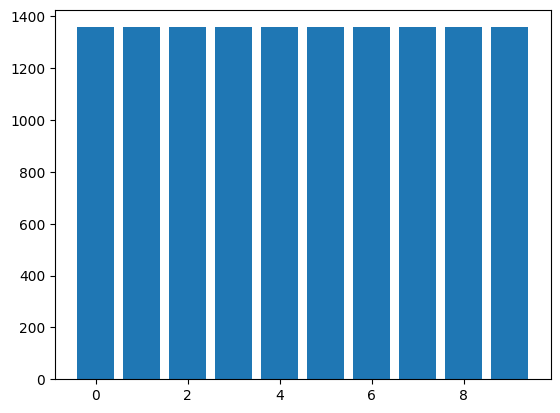

In [181]:
def test():
    unique, count = np.unique(writer_info[:, 0], return_counts=True)
    print(unique, count)
    plt.bar(unique, count)

test()

images.dtype=torch.float32
labels.dtype=torch.int64
images.shape=torch.Size([9, 1, 81, 81])
images[0]=tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


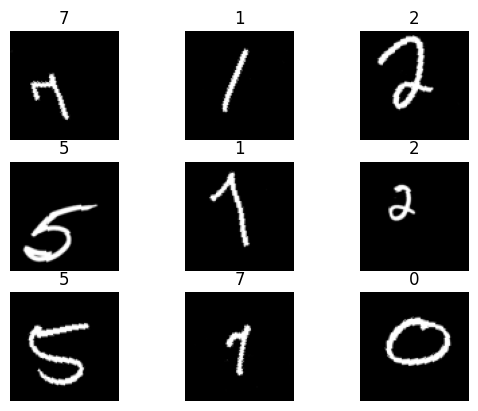

In [4]:
def test_big_dataset():
    from itertools import islice
    print(f"{writer_info.shape=}")
    print(images.shape)

    print(f"{writer_info[3]=}")
    temp = 1358*2 - 1
    print(writer_info[:, 0][temp+1])
    for i, (image, info) in enumerate(islice(zip(images, writer_info), temp, temp + 9)):
        plt.subplot(3, 3, i + 1)
        plt.axis("off")
        plt.title(info[0])
        plt.imshow(image, cmap="gray")

        if i == 8:
            break

# test_big_dataset()

class HWDPlus(data.Dataset):
    def __init__(self, image_file, writer_info_file, transforms=None):
        self.images = np.expand_dims(np.load(image_file), axis=-1)
        self.writer_info = np.load(writer_info_file).astype(np.int64)
        self.labels = self.writer_info[:, 0]
        self.transforms = transforms

        self.len = self.images.shape[0]

    def __getitem__(self, index):
        if self.transforms is not None:
            image = self.transforms(self.images[index])
        else:
            image = self.images[index]
        return image, self.labels[index]

    def __len__(self):
        return self.len

def get_loaders(batch_size=32):
    from pathlib import Path
    transforms = v2.Compose([
        # v2.RandomZoomOut(),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((81, 81), antialias=True),
        v2.Normalize((0.5,), (0.5,)),
        v2.Lambda(lambda x: -x + 1),
        v2.RandomRotation(30),
    ])

    dataset = HWDPlus(
        "/home/kanna/ml/datasets/Images(500x500)-001.npy",
        "/home/kanna/ml/datasets/WriterInfo.npy",
        transforms,
    )

    train, val = data.random_split(dataset, [11_000, 2_580])

    train_loader = data.DataLoader(
        train,
        batch_size=batch_size,
        shuffle=True,
        num_workers=5,
        pin_memory=True
    )

    val_loader = data.DataLoader(
        val,
        batch_size=batch_size,
        num_workers=5,
        pin_memory=True
    )

    return train_loader, val_loader


def test():
    train_loader, val_loader = get_loaders(9)

    images, labels = next(iter(train_loader))
    
    print(f"{images.dtype=}")
    print(f"{labels.dtype=}")

    print(f"{images.shape=}")
    torch.set_printoptions(profile="default")
    print(f"{images[0]=}")

    assert len(images) == 9, f"{len(image)} should be 9"
    for i, (image, label) in enumerate(zip(images, labels)):
        plt.subplot(3, 3, i + 1)
        plt.axis("off")
        plt.title(label.item())
        plt.imshow(image.reshape(81, 81), cmap="gray")


test()


In [5]:
class LinearLayer(L.LightningModule):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(in_features, out_features, bias=bias),
            nn.ReLU(inplace=True),
            # nn.Dropout(0.25),
        )

    def forward(self, x):
        return self.layer(x)

class Intepreter(L.LightningModule):
    def __init__(self, input_dim):
        super().__init__()
        self.layers = nn.Sequential(
            LinearLayer(input_dim, 512),
            LinearLayer(512, 256),
            LinearLayer(256, 256),
            LinearLayer(256, 32),
        )
        self.classifier = nn.Linear(32, 10)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.loss = nn.NLLLoss().to(device)

        self.train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.layers(x)
        x = self.classifier(x)
        return self.log_softmax(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, on_epoch=True)

        self.train_acc(y_hat, y)
        self.log("train_acc", self.train_acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        self.valid_acc(self.log_softmax(y_hat), y)
        self.log("val_acc", self.valid_acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


def test():
    test_input = torch.randn(10, 10)
    out = LinearLayer(10, 2)(test_input)

    print(out.shape)

    model = Intepreter(10**2)
    test_input = torch.randn(10, 10**2)
    out = model(test_input)
    print(out.shape)
    # print(F.softmax(out, dim=1))
test()

torch.Size([10, 2])
torch.Size([10, 10])


In [19]:
def main():
    train_loader, val_loader = get_loaders(32)

    global intepreter
    intepreter = Intepreter(81**2)
    logger = TensorBoardLogger(config["logger"], name=config["log_name"])
    checkpoint_callback = ModelCheckpoint(
        dirpath=config["checkpoint_dir"],
        save_top_k=1,
        verbose=True,
        monitor='val_acc',
        mode='max',
        filename=config["checkpoint_filename"],
    )

    trainer = L.Trainer(
        accelerator="gpu",
        max_epochs=10,
        logger=logger,
        callbacks=[TQDMProgressBar(refresh_rate=10), checkpoint_callback],
        precision="16-mixed",
        profiler="simple",
    )

    trainer.fit(intepreter, train_loader, val_loader)


main()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kanna/.conda/envs/torch/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /home/kanna/ml/models/badapple_in_nn exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | layers      | Sequential         | 3.6 M 
1 | classifier  | Linear             | 330   
2 | log_softmax | LogSoftmax         | 0     
3 | loss        | NLLLoss            | 0     
4 | train_acc   | MulticlassAccuracy | 0     
5 | valid_acc   | MulticlassAccuracy | 0     
---------------------------------------------------
3.6 M     Trainable params
0         Non-trainable params
3.6 M     Total params
14.262    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 344: 'val_acc' reached 0.59070 (best 0.59070), saving model to '/home/kanna/ml/models/badapple_in_nn/bad_apple_nn-epoch=00-val_acc=0.59.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 688: 'val_acc' reached 0.74070 (best 0.74070), saving model to '/home/kanna/ml/models/badapple_in_nn/bad_apple_nn-epoch=01-val_acc=0.74.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1032: 'val_acc' reached 0.78915 (best 0.78915), saving model to '/home/kanna/ml/models/badapple_in_nn/bad_apple_nn-epoch=02-val_acc=0.79.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 1376: 'val_acc' reached 0.83333 (best 0.83333), saving model to '/home/kanna/ml/models/badapple_in_nn/bad_apple_nn-epoch=03-val_acc=0.83.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1720: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 2064: 'val_acc' reached 0.85736 (best 0.85736), saving model to '/home/kanna/ml/models/badapple_in_nn/bad_apple_nn-epoch=05-val_acc=0.86.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 2408: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 2752: 'val_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 3096: 'val_acc' reached 0.85891 (best 0.85891), saving model to '/home/kanna/ml/models/badapple_in_nn/bad_apple_nn-epoch=08-val_acc=0.86.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 3440: 'val_acc' reached 0.88178 (best 0.88178), saving model to '/home/kanna/ml/models/badapple_in_nn/bad_apple_nn-epoch=09-val_acc=0.88.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
FIT Profiler Report

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                              	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [6]:
%tensorboard --logdir=~/ml/logs/badapple_in_nn

UsageError: Line magic function `%tensorboard` not found.


torch.return_types.max(
values=tensor([0.9711, 0.8848, 1.0000, 1.0000, 0.9988, 0.9774, 0.9428, 0.9662, 0.9983],
       grad_fn=<MaxBackward0>),
indices=tensor([3, 6, 1, 3, 9, 9, 5, 5, 4]))
tensor([3, 6, 1, 3, 9, 9, 5, 5, 4])
tensor([3, 6, 1, 3, 9, 9, 5, 5, 4])


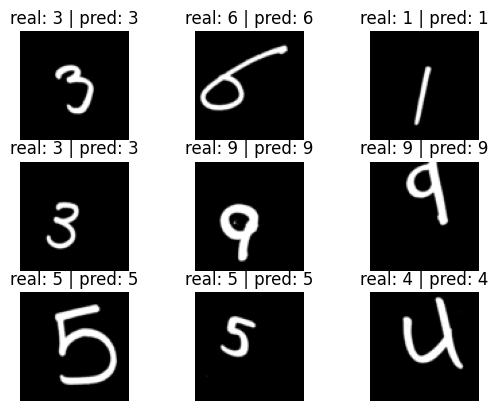

In [10]:
def test_model():
    train_loader, val_loader = get_loaders(9)
    images, labels = next(iter(val_loader))
    out = F.softmax(intepreter(images), dim=1)
    print(out.max(dim=1))
    predictions = out.argmax(dim=1)

    print(predictions)
    print(labels)

    for i, (image, prediction, label) in enumerate(zip(images, predictions, labels)):
        plt.subplot(3, 3, i + 1)
        plt.axis("off")
        plt.title(f"real: {label.item()} | pred: {prediction.item()}")
        plt.imshow(image.reshape(81, 81), cmap="gray")

test_model()

In [9]:
%load_ext autoreload
%autoreload 2


In [17]:
def save_model():
    import onnx
    from pathlib import Path
    file_path = Path(config["onnx_path"])
    file_path.parent.mkdir(parents=True, exist_ok=True)
    input_sample = torch.randn(1, 81**2)
    intepreter.to_onnx(file_path.absolute(), input_sample, export_params=True)

save_model()

In [6]:
import cv2 
from PIL import Image

def convert(vidfile, startms, idoffset):
    frames = []

    cam = cv2.VideoCapture(vidfile)
    fps = cam.get(cv2.CAP_PROP_FPS)
    ms_per_frame = 1000 / fps

    cam.set(cv2.CAP_PROP_POS_MSEC, startms + idoffset * ms_per_frame)

    pos_after_offset = int(cam.get(cv2.CAP_PROP_POS_FRAMES))
    total_frames = int(cam.get(cv2.CAP_PROP_FRAME_COUNT)) - pos_after_offset

    print('Extracting Frames...')
    with tqdm(total=total_frames) as progress:
        while True:
            frame_num = int(cam.get(cv2.CAP_PROP_POS_FRAMES)) - pos_after_offset
            progress.update(1)

            ret, frame = cam.read()
            if not ret: break
            frames.append(Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)))

    cam.release()

    print(f"{ms_per_frame=}")

    return frames

frames = convert(config["badapple_video"], 0, 0)
print(f"{len(frames)=}")
print(f"{frames[0]=}")
    

Extracting Frames...


6573it [00:05, 1237.71it/s]                          

ms_per_frame=33.333333333333336
len(frames)=6572
frames[0]=<PIL.Image.Image image mode=L size=480x360 at 0x7F4001FF82B0>


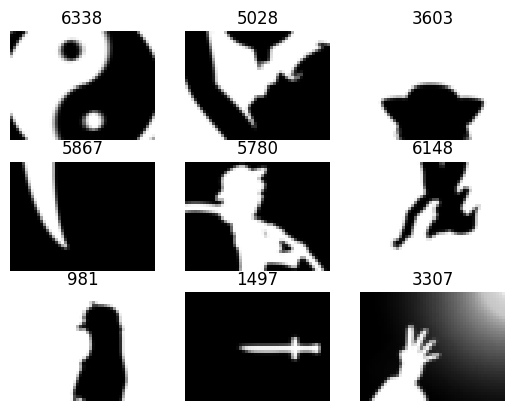

In [7]:
from random import choices
def test():
    random_frames = choices(range(len(frames)), k=9)

    transforms = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Resize((36, 48), antialias=True),
    ])

    for i, frame_number in enumerate(random_frames):
        image = transforms(frames[frame_number]).squeeze(0)
        plt.subplot(3, 3, i + 1)
        plt.axis("off")
        plt.title(frame_number)
        plt.imshow(image, cmap="gray")

test()

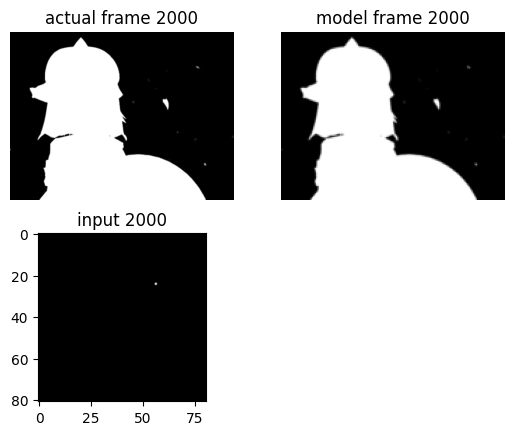

In [9]:
class AppleEncoderDecoder(L.LightningModule):
    def __init__(self, frames, input_size=81**2):
        super().__init__()
        self.transforms = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize((36, 48), antialias=True),
        ])

        self.encoder = nn.Linear(input_size, 36*48, bias=False)
        self.decoder = nn.Linear(36*48, input_size, bias=False)

        for frame, input_pixel, decoder_pixel in zip(frames, self.encoder.weight.transpose(0, 1), self.decoder.weight):
            image = self.transforms(frame).squeeze(0)
            # print(image)
            # print(input_pixel.data.shape)
            # print(image.view(-1).shape)
            input_pixel.data[:] = image.view(-1)
            decoder_pixel.data[:] = -image.view(-1)

    def forward(self, x):
        with torch.no_grad():
            x = self.encoder(x)
        return self.decoder(x)

class AppleEncoder(L.LightningModule):
    def __init__(self, frames, input_size=81**2, display_size=(36, 48)):
        super().__init__()
        self.transforms = v2.Compose([
            v2.ToImage(),
            v2.ToDtype(torch.float32, scale=True),
            v2.Resize(display_size, antialias=True),
        ])

        multiply = lambda x, y: x * y

        self.encoder = nn.Linear(input_size, multiply(*display_size), bias=False)

        for frame, input_pixel in zip(frames, self.encoder.weight.transpose(0, 1)):
            image = self.transforms(frame).squeeze(0)
            input_pixel.data[:] = image.view(-1)

    def forward(self, x):
        with torch.no_grad():
            return self.encoder(x)



def test():
    test_frame_number = 2000
    display_size = (360//3, 480//3)
    plt.subplot(2, 2, 1)
    plt.axis("off")
    plt.title(f"actual frame {test_frame_number}")
    plt.imshow(frames[test_frame_number], cmap="gray")

    model = AppleEncoder(frames, 81**2, display_size=display_size)
    with torch.no_grad():
        test_input = torch.zeros(1, 81**2)
        test_input[0][test_frame_number] = 1
        out = model.encoder(test_input)

    plt.subplot(2, 2, 2)
    plt.axis("off")
    plt.title(f"model frame {test_frame_number}")
    plt.imshow(out[0].reshape(*display_size), cmap="gray")

    plt.subplot(2, 2, 3)
    plt.title(f"input {test_frame_number}")
    plt.imshow(test_input[0].reshape(81, 81), cmap="gray")

    # with torch.no_grad():
    #     out = model.decoder(out)

    # plt.subplot(2, 2, 4)
    # plt.title(f"model frame {test_frame_number}")
    # plt.imshow(out[0].reshape(81, 81), cmap="gray")


test()

In [118]:
class BadAppleInNN(L.LightningModule):
    def __init__(self, frames, input_size=81**2):
        super().__init__()
        self.encoder = AppleEncoder(frames, input_size)
        self.encoder_output_size = 36*48
        self.interpreter = Intepreter(self.encoder_output_size)
        device = "cuda" if torch.cuda.is_available() else "cpu"
        self.loss = nn.NLLLoss().to(device)
        self.softmax_log = nn.LogSoftmax(dim=1)

        self.train_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)
        self.valid_acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=10)

    def forward(self, x):
        x = torch.flatten(x, 1)
        with torch.no_grad():
            x = self.encoder(x)
        x = self.interpreter(x)
        return self.softmax_log(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        self.log("train_loss", loss, on_epoch=True)

        self.train_acc(y_hat, y)
        self.log("train_acc", self.train_acc, on_epoch=True)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        self.valid_acc(y_hat, y)
        self.log("valid_acc", self.valid_acc, on_epoch=True)

        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

def test():
    test_input = torch.rand((1, 81**2))
    model = BadAppleInNN(frames)

    out = model(test_input)
    print(out.shape)

test()



torch.Size([1, 10])


In [119]:
def train_badapple_in_nn():
    train_loader, val_loader = get_loaders(30)
    model = BadAppleInNN(frames)
    logger = TensorBoardLogger(config["logger"], name="encoder-bad-apple")
    checkpoint_callback = ModelCheckpoint(
        dirpath=config["checkpoint_dir"],
        save_top_k=1,
        verbose=True,
        monitor='valid_acc',
        mode='max',
        filename=config["checkpoint_filename"],
    )

    trainer = L.Trainer(
        accelerator="gpu",
        max_epochs=10,
        logger=logger,
        callbacks=[TQDMProgressBar(refresh_rate=10), checkpoint_callback],
        precision="16-mixed",
        # profiler="simple",
    )
    trainer.fit(model, train_loader, val_loader)

train_badapple_in_nn()

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kanna/.conda/envs/torch/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory /home/kanna/Documents/python/notebooks/badapple_in_nn/~/ml/models/badapple_in_nn exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type               | Params
---------------------------------------------------
0 | encoder     | AppleEncoder       | 11.3 M
1 | interpreter | Intepreter         | 1.1 M 
2 | loss        | NLLLoss            | 0     
3 | softmax_log | LogSoftmax         | 0     
4 | train_acc   | MulticlassAccuracy | 0     
5 | valid_acc   | MulticlassAccuracy | 0     
---------------------------------------------------
12.4 M    Trainable params
0         Non-trainable params
12.4 M    Total params
49.713    Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 367: 'valid_acc' reached 0.09651 (best 0.09651), saving model to '/home/kanna/Documents/python/notebooks/badapple_in_nn/~/ml/models/badapple_in_nn/badapple_in_nn-epoch=00-val_acc=0.00-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 734: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1101: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 1468: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, global step 1835: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5, global step 2202: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6, global step 2569: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, global step 2936: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, global step 3303: 'valid_acc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, global step 3670: 'valid_acc' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
